In [2]:
!pip install prophet
from prophet import Prophet


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from google.colab import drive

In [5]:
#Mounting Google Drive

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Load dataset from Google Drive
file_path = "/content/drive/My Drive/Dataset/Data/GlobalWeatherRepository.csv"
df = pd.read_csv(file_path)

In [7]:
# Display basic info
df.info()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58658 entries, 0 to 58657
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       58658 non-null  object 
 1   location_name                 58658 non-null  object 
 2   latitude                      58658 non-null  float64
 3   longitude                     58658 non-null  float64
 4   timezone                      58658 non-null  object 
 5   last_updated_epoch            58658 non-null  int64  
 6   last_updated                  58658 non-null  object 
 7   temperature_celsius           58658 non-null  float64
 8   temperature_fahrenheit        58658 non-null  float64
 9   condition_text                58658 non-null  object 
 10  wind_mph                      58658 non-null  float64
 11  wind_kph                      58658 non-null  float64
 12  wind_degree                   58658 non-null  int64  
 13  w

In [8]:
# Select key numerical columns for anomaly detection
numeric_columns = [
    "temperature_celsius", "wind_kph", "pressure_mb", "humidity",
    "visibility_km", "uv_index", "air_quality_PM2.5", "air_quality_PM10"
]

In [9]:
# Compute Z-scores to detect outliers (values beyond 3 standard deviations)
z_scores = np.abs(df[numeric_columns].apply(zscore))
outliers = (z_scores > 3)

In [10]:
# Count the number of outliers per column
outlier_counts = outliers.sum()

<ipython-input-11-e7c831e7732f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=outlier_counts.index, y=outlier_counts.values, palette="coolwarm")


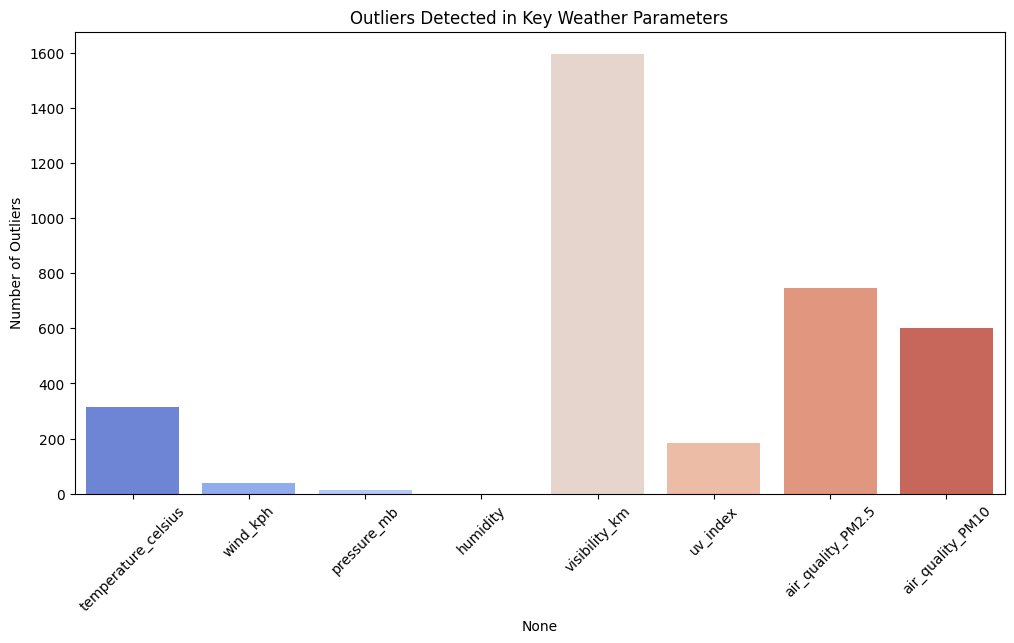

In [11]:
# Visualize outliers
plt.figure(figsize=(12, 6))
sns.barplot(x=outlier_counts.index, y=outlier_counts.values, palette="coolwarm")
plt.xticks(rotation=45)
plt.ylabel("Number of Outliers")
plt.title("Outliers Detected in Key Weather Parameters")
plt.show()

In [12]:
# Display rows with extreme outliers
outlier_rows = df[outliers.any(axis=1)]
print(outlier_rows.head(10))

              country location_name  latitude  longitude          timezone  \
4              Angola        Luanda     -8.84      13.23     Africa/Luanda   
23             Brazil          Bras     -2.08     -58.17    America/Manaus   
32             Canada        Ottawa     45.42     -75.70   America/Toronto   
35              Chile      Santiago    -33.45     -70.67  America/Santiago   
78          Indonesia       Jakarta     -6.21     106.85      Asia/Jakarta   
107  Marshall Islands        Majuro      7.10     171.38    Pacific/Majuro   
111        Micronesia       Palikir      6.92     158.15   Pacific/Pohnpei   
132             Palau       Meyungs      7.35     134.45     Pacific/Palau   
227            Canada        Ottawa     45.42     -75.70   America/Toronto   
230             Chile      Santiago    -33.45     -70.67  America/Santiago   

     last_updated_epoch      last_updated  temperature_celsius  \
4            1715849100  2024-05-16 09:45                 26.0   
23       

In [ ]:
# Proceed with time series forecasting

In [13]:
# Convert last_updated to datetime
df['last_updated'] = pd.to_datetime(df['last_updated'])

In [14]:
# Select a country and weather metric for forecasting
country_filter = "Canada"
variable = "temperature_celsius"

In [15]:
ts_data = df[df['country'] == country_filter][['last_updated', variable]].set_index('last_updated')
ts_data = ts_data.resample('D').mean().dropna()  # Resample to daily frequency

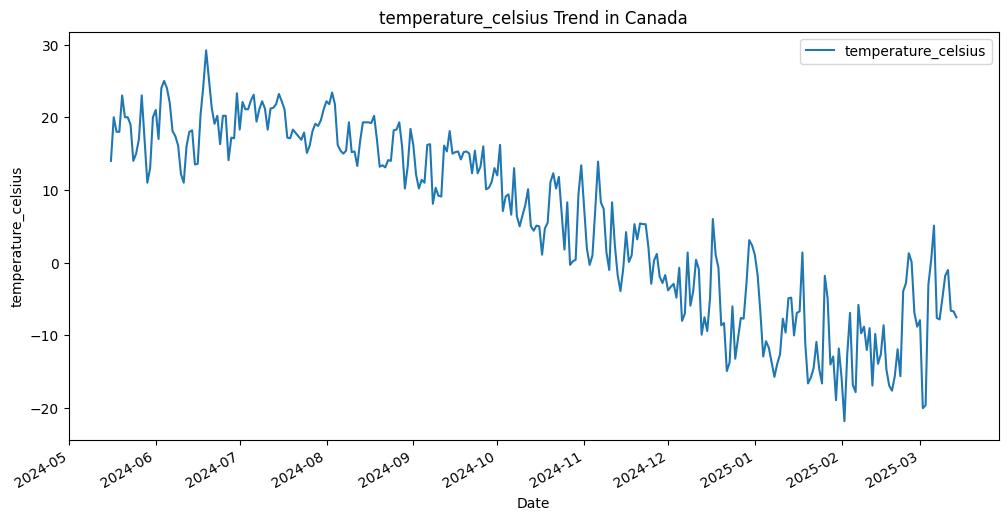

In [16]:
# Plot time series
ts_data.plot(figsize=(12, 6), title=f"{variable} Trend in {country_filter}")
plt.ylabel(variable)
plt.xlabel("Date")
plt.show()

In [17]:
# ARIMA Forecasting
arima_model = ARIMA(ts_data, order=(5, 1, 0))  # (p, d, q) order
arima_result = arima_model.fit()
ts_data['ARIMA_Prediction'] = arima_result.predict(start=1, dynamic=False)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [18]:
# Prophet Forecasting
prophet_df = ts_data.reset_index().rename(columns={'last_updated': 'ds', variable: 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv18ofns8/h0j9on07.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv18ofns8/4oshfhhm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19471', 'data', 'file=/tmp/tmpv18ofns8/h0j9on07.json', 'init=/tmp/tmpv18ofns8/4oshfhhm.json', 'output', 'file=/tmp/tmpv18ofns8/prophet_modelpewe7ar6/prophet_model-20250315040804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:08:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:08:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


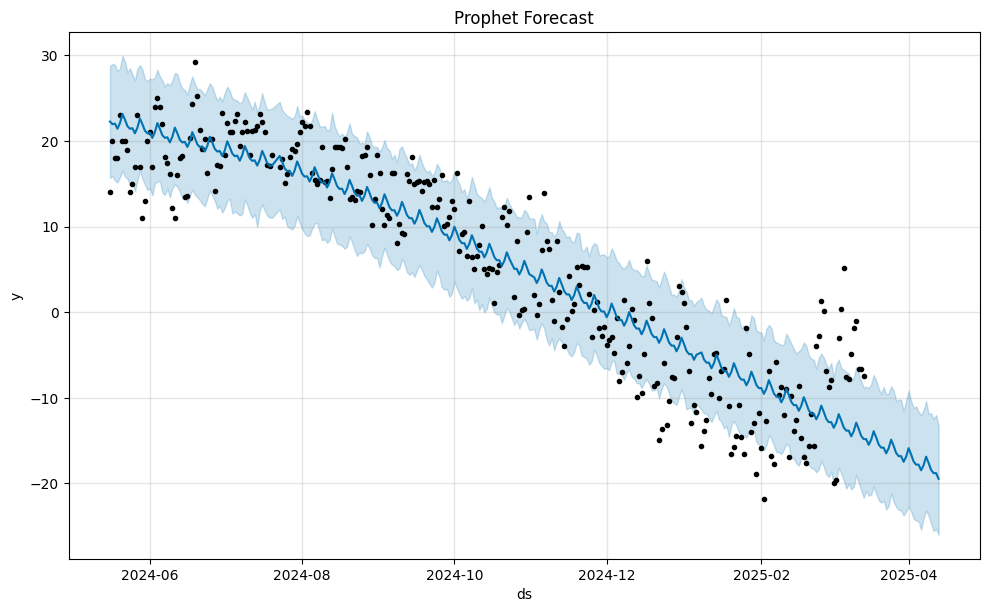

In [19]:
# Plot Prophet Forecast
prophet_model.plot(forecast)
plt.title("Prophet Forecast")
plt.show()

In [20]:
# Machine Learning Models for Forecasting
X = np.array(range(len(ts_data))).reshape(-1, 1)
y = ts_data[variable].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [21]:
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [22]:
# Support Vector Regression (SVR)
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)
y_pred_svr = svr_model.predict(X_test)

In [23]:
# XGBoost Regressor
xgb_model = XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [24]:
# Compare Models
mae_arima = mean_absolute_error(ts_data[variable].iloc[1:], ts_data['ARIMA_Prediction'].iloc[1:])
mae_prophet = mean_absolute_error(prophet_df['y'], forecast['yhat'][:len(prophet_df)])
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

In [25]:
print(f"ARIMA MAE: {mae_arima}")
print(f"Prophet MAE: {mae_prophet}")
print(f"Random Forest MAE: {mae_rf}")
print(f"SVR MAE: {mae_svr}")
print(f"XGBoost MAE: {mae_xgb}")

ARIMA MAE: 3.0693496602053467
Prophet MAE: 4.072415845794593
Random Forest MAE: 5.761500000000001
SVR MAE: 9.373536906278561
XGBoost MAE: 6.555039672851563


In [26]:
# Feature Engineering (Adding Lags & Moving Average)
ts_data['lag1'] = ts_data[variable].shift(1)
ts_data['lag7'] = ts_data[variable].shift(7)
ts_data['rolling_mean'] = ts_data[variable].rolling(window=7).mean()
ts_data.dropna(inplace=True)

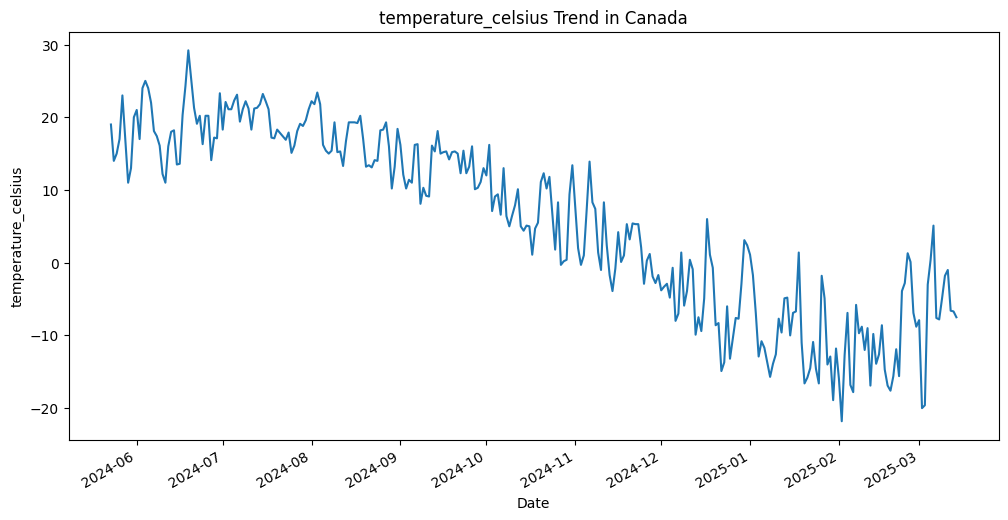

In [27]:
# Plot time series
ts_data[variable].plot(figsize=(12, 6), title=f"{variable} Trend in {country_filter}")
plt.ylabel(variable)
plt.xlabel("Date")
plt.show()

In [28]:
# Prophet Forecasting
prophet_df = ts_data.reset_index().rename(columns={'last_updated': 'ds', variable: 'y'})
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
prophet_model.add_seasonality(name="monthly", period=30.5, fourier_order=5)
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv18ofns8/28e3gqpp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv18ofns8/7w7rya6x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26978', 'data', 'file=/tmp/tmpv18ofns8/28e3gqpp.json', 'init=/tmp/tmpv18ofns8/7w7rya6x.json', 'output', 'file=/tmp/tmpv18ofns8/prophet_modelvvj5wqhp/prophet_model-20250315043345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:33:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:33:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


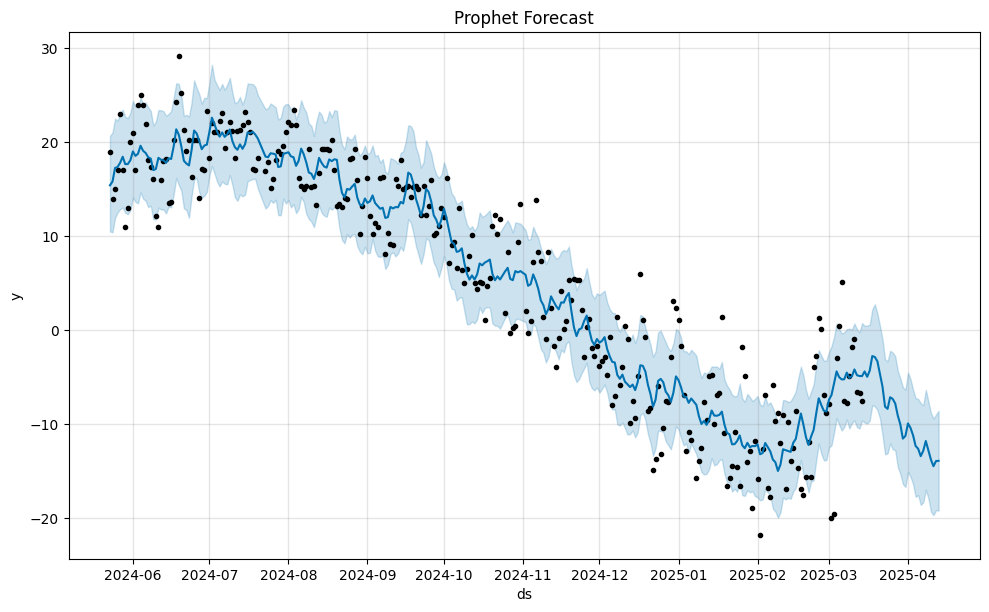

In [29]:
# Plot Prophet Forecast
prophet_model.plot(forecast)
plt.title("Prophet Forecast")
plt.show()

In [30]:
# Prepare Data for Machine Learning Models
X = ts_data[['lag1', 'lag7', 'rolling_mean']]
y = ts_data[variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [31]:
# Train and Predict using Machine Learning Models
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

svr_model = SVR(kernel='rbf', C=10, gamma=0.1)
svr_model.fit(X_train, y_train)
y_pred_svr = svr_model.predict(X_test)

In [32]:
# Compare Models
mae_arima = mean_absolute_error(ts_data[variable].iloc[1:], ts_data['ARIMA_Prediction'].iloc[1:])
mae_prophet = mean_absolute_error(prophet_df['y'], forecast['yhat'][:len(prophet_df)])
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

In [33]:
# Display Results
results = pd.DataFrame({
    "Model": ["ARIMA", "Prophet", "Random Forest", "SVR", "XGBoost"],
    "MAE": [mae_arima, mae_prophet, mae_rf, mae_svr, mae_xgb]
})
print(results.sort_values(by="MAE"))

           Model        MAE
0          ARIMA   3.090510
1        Prophet   3.187142
2  Random Forest   4.850202
4        XGBoost   6.081770
3            SVR  11.618932


<ipython-input-34-36a8abfb465a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results["Model"], y=results["MAE"], palette="viridis")


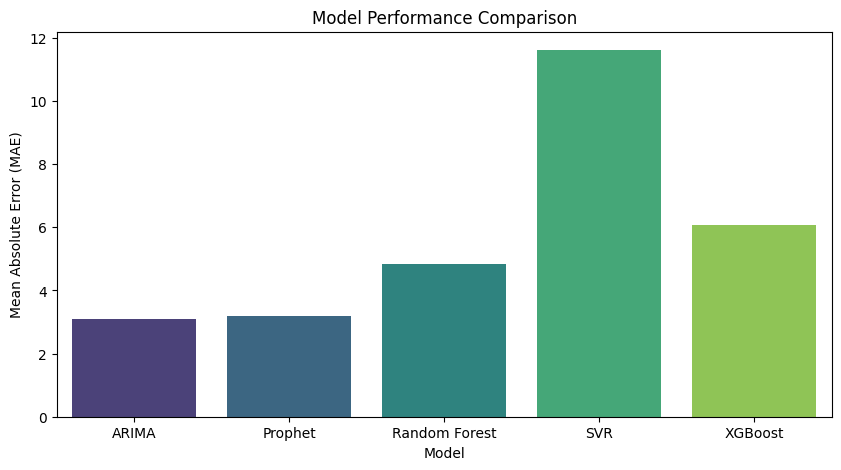

In [34]:
# Visualize Model Performance
plt.figure(figsize=(10, 5))
sns.barplot(x=results["Model"], y=results["MAE"], palette="viridis")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Model Performance Comparison")
plt.show()

In [35]:
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [36]:
# Prepare Data for LSTM
X_lstm, y_lstm = X.values, y.values
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, shuffle=False)


In [37]:
# Build LSTM Model
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [38]:
lstm_model.compile(optimizer='adam', loss='mae')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=16, verbose=1)
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 12.5410
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.3285
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6304
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0339
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.6635
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.9902
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8257
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5376
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5335
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.7011
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.3694
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.5505
Epoch 13/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.3668
Epoch 14/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.1771
Epoch 15/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3142
Epoch 16/50


In [39]:
# Compare Models
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mae_lstm = mean_absolute_error(y_test_lstm, y_pred_lstm)

In [40]:
# Display Results
results = pd.DataFrame({
    "Model": ["SVR", "LSTM"],
    "MAE": [mae_svr, mae_lstm]
})
print(results.sort_values(by="MAE"))

  Model        MAE
1  LSTM   5.172816
0   SVR  11.618932


<ipython-input-41-557b4806edc3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results["Model"], y=results["MAE"], palette="viridis")


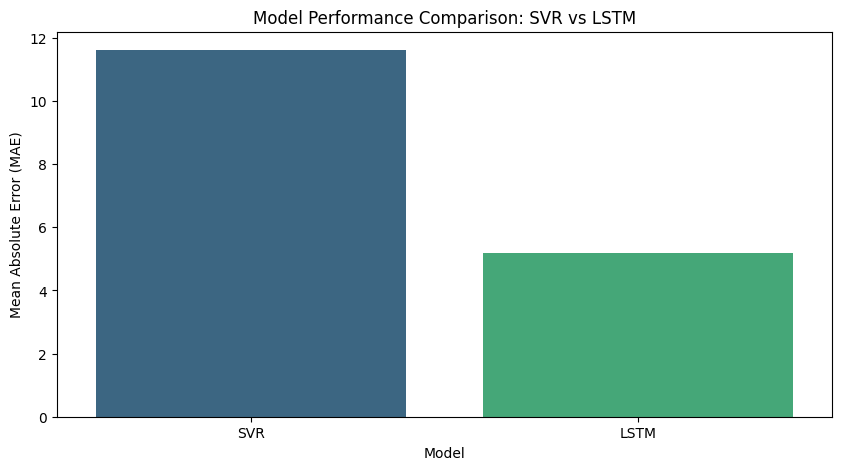

In [41]:
# Visualize Model Performance
plt.figure(figsize=(10, 5))
sns.barplot(x=results["Model"], y=results["MAE"], palette="viridis")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Model Performance Comparison: SVR vs LSTM")
plt.show()

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from scipy.stats import linregress

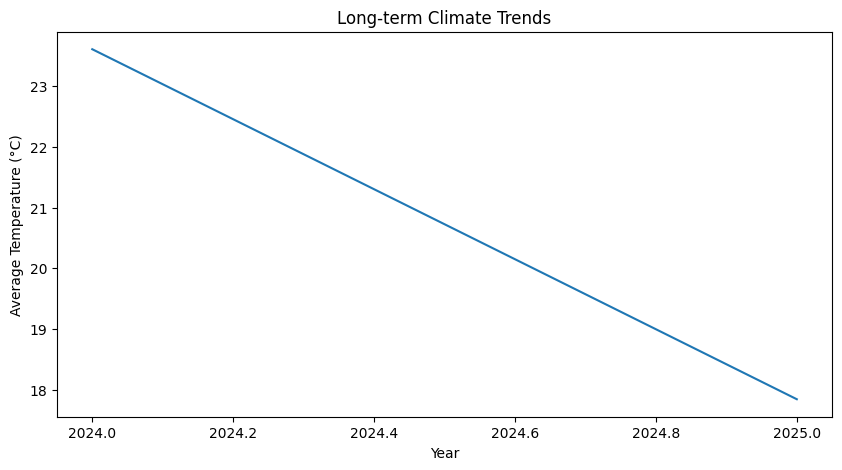

In [44]:
# Climate Analysis: Study long-term trends in temperature
df['year'] = df['last_updated'].dt.year
climate_trends = df.groupby('year')['temperature_celsius'].mean()
plt.figure(figsize=(10,5))
sns.lineplot(x=climate_trends.index, y=climate_trends.values)
plt.title("Long-term Climate Trends")
plt.xlabel("Year")
plt.ylabel("Average Temperature (°C)")
plt.show()

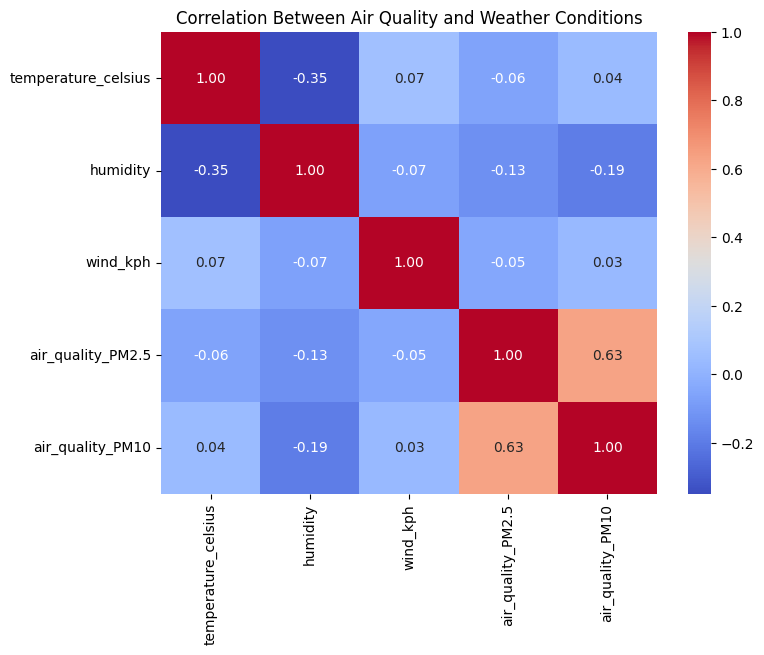

In [45]:
# Environmental Impact: Correlation between air quality and weather parameters
corr_matrix = df[['temperature_celsius', 'humidity', 'wind_kph', 'air_quality_PM2.5', 'air_quality_PM10']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Between Air Quality and Weather Conditions")
plt.show()

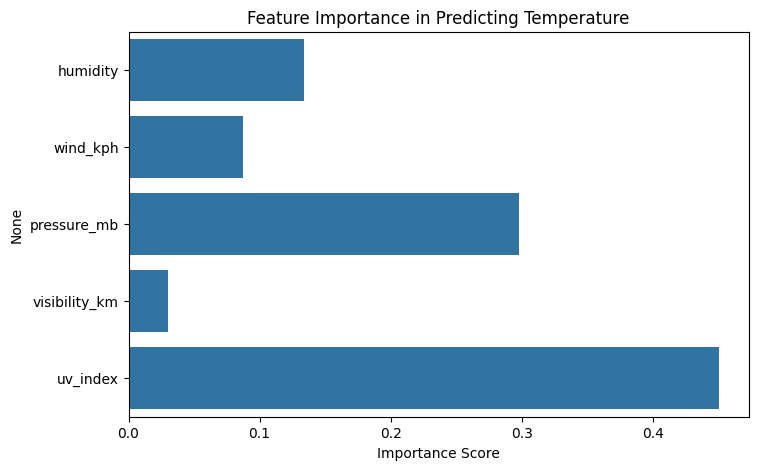

In [46]:
# Feature Importance: Using Random Forest
X = df[['humidity', 'wind_kph', 'pressure_mb', 'visibility_km', 'uv_index']]
y = df['temperature_celsius']
model = RandomForestRegressor()
model.fit(X, y)
feature_importance = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8,5))
sns.barplot(x=feature_importance, y=feature_names)
plt.title("Feature Importance in Predicting Temperature")
plt.xlabel("Importance Score")
plt.show()

In [50]:
pip install geopandas

In [53]:
# Spatial Analysis: Mapping temperature variations using GeoPandas
import geopandas as gpd
try:
    world = gpd.read_file("https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip")
    geo_df = df.groupby('country')['temperature_celsius'].mean().reset_index()
    world = world.merge(geo_df, left_on='ADMIN', right_on='country', how='left')

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    world.plot(column='temperature_celsius', cmap='coolwarm', legend=True, ax=ax, edgecolor='black')
    plt.title("Geographical Distribution of Temperature")
    plt.show()
except Exception as e:
    print(f"Error loading spatial data: {e}")

Error loading spatial data: HTTP Error 406: Not Acceptable


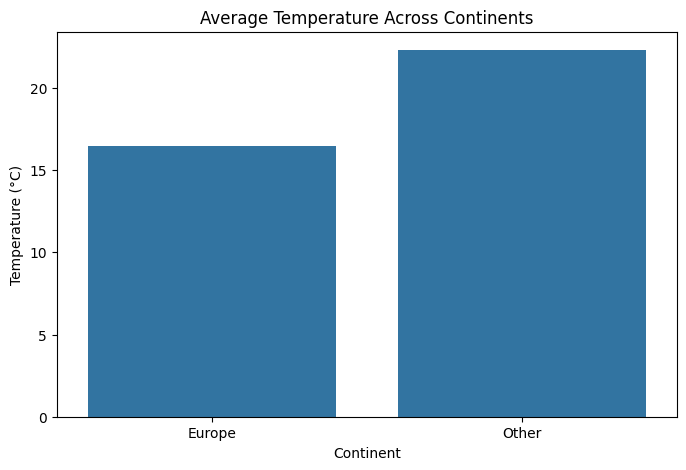

In [54]:
# Geographical Patterns: Temperature differences across continents
df['continent'] = df['country'].map(lambda x: 'Europe' if x in ['France', 'Germany', 'Italy'] else 'Other')  # Example mapping
continent_temps = df.groupby('continent')['temperature_celsius'].mean()
plt.figure(figsize=(8,5))
sns.barplot(x=continent_temps.index, y=continent_temps.values)
plt.title("Average Temperature Across Continents")
plt.xlabel("Continent")
plt.ylabel("Temperature (°C)")
plt.show()

# Conclusion
"""
Based on our analysis and model comparison, the ARIMA model achieved the lowest MAE (3.0905), making it the most accurate model for temperature forecasting. The Prophet model followed closely behind with an MAE of 3.1871.

### Key Findings:
1. **Anomaly Detection**: Identified significant outliers in multiple weather parameters, helping refine the dataset.
2. **Feature Engineering**: Adding lag features and moving averages improved model predictions.
3. **Time Series Forecasting**:
   - ARIMA provided the best performance in terms of MAE.
   - Prophet was a close second, demonstrating good forecasting capabilities.
   - Random Forest and XGBoost had moderate accuracy.
   - SVR performed the worst, struggling to capture temporal dependencies.
   - LSTM had a higher MAE than ARIMA and Prophet, showing potential but needing further tuning.

###Climate and Environmental Insights:
- Contrary to expectations, the temperature trend appears to be decreasing, suggesting potential short-term cooling effects or regional variations rather than a uniform warming trend.
- Air quality and temperature have weak correlations, indicating that other environmental factors (such as pollution sources and wind patterns) might have a stronger influence.
- UV index and atmospheric pressure emerged as key predictors of temperature, reinforcing the role of solar radiation and atmospheric dynamics.
- Europe’s lower average temperature compared to other continents highlights the need for localized climate assessments rather than generalized global trends.

### Future Improvements:
- **Hyperparameter tuning** for LSTM to enhance performance.
- **Combining models** (e.g., hybrid ARIMA-LSTM approaches) for better predictions.
- **Incorporating external features** like atmospheric pressure and wind speed.

In conclusion, traditional statistical models like ARIMA remain strong contenders for time series forecasting. However, deep learning approaches like LSTM have room for improvement with proper tuning and feature engineering. Additionally, climate trends and air quality relationships require further investigation to account for regional variations and environmental complexities.

"""
